# Playbook 2 — Model de Clustering (K-Means)

Aquest notebook correspon a la **Part 2 (Model de Machine Learning)** del projecte de clustering.  
Llegeix el **CSV final generat al Playbook 1 (ETL)** i entrena un model **K-Means** per descobrir **la posicio de jugadors** .  

**Objectius d'aquest Playbook 2:**
- Carregar el dataset net (CSV) del Playbook 1
- Seleccionar variables rellevants per al clustering i justificar-les
- Estandarditzar les dades
- Escollir el nombre de clústers (*k*) amb **Elbow** i **Silhouette**
- Entrenar **K-Means**, assignar clústers i generar una **taula resum per clúster**
- Afegir **noms esportius** als clústers i una **visualització simple**


## Justificació de les variables seleccionades

Per construir el model de clustering s'han seleccionat variables **numèriques** que descriuen el rendiment del jugador i el seu estil de joc.  
S'han descartat identificadors (IDs), noms i camps contextuals perquè no aporten informació de com es el jugador i poden marejar al model.

**Criteris de selecció:**
- **Producció ofensiva**: punts per partit
- **Creació de joc**: assistències
- **Aportació física**: rebots
- **Control / risc**: pèrdues
- **Eficiència**: percentatges (FG, eFG)
- **Tendència de tir**: ús de 2p i ús de 3p

Aquesta combinació permet detectar rols típics (tiradors, interiors, bases, jugadors polivalents).


In [4]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt


In [5]:


csv_path = "FEB3_Playbook2_ready.csv"
for p in csv_path:
    try:
        _ = open(p, "r", encoding="utf-8")
        csv_path = p
        break
    except Exception:
        pass

if csv_path is None:
    raise FileNotFoundError(
        "No he trobat el CSV. Col·loca'l a 'data/FEB3_Playbook2_ready.csv' "
        "o al mateix directori del notebook."
    )

df = pd.read_csv(csv_path)
print("CSV carregat:", csv_path)
print("Mida:", df.shape)
df.head()


CSV carregat: FEB3_Playbook2_ready.csv
Mida: (4755, 11)


,player_feb_id,season_id,games,avg_min,avg_ast,avg_trb,avg_tov,avg_2pa,avg_3pa,fg2_pct,fg3_pct
0,2816298,2025,12,24.131944,1.000000,6.166667,1.833333,6.250000,5.250000,0.388757,0.387037
1,2648564,2023-2024,26,33.455128,1.500000,8.153846,3.000000,10.961538,0.961538,0.607855,0.186275
2,1384586,2025,12,27.731944,3.833333,5.250000,2.833333,4.333333,1.500000,0.395238,0.435185
3,1246691,2023-2024,23,23.016667,2.739130,1.869565,2.478261,2.478261,3.521739,0.417293,0.322826
4,1451287,2023-2024,13,26.937179,1.538462,6.538462,2.692308,9.384615,0.384615,0.360577,0.000000


## 1) Selecció de *features* per al clustering

Primer intentarem utilizar un conjunt de columnes.  


In [6]:
# Columnes del csv
expected_features = [
    "avg_pts", "avg_ast", "avg_trb", "avg_tov",
    "fg_pct", "efg_pct",
    "usage_2p", "usage_3p"
]

def pick_features(df: pd.DataFrame):
    # Si totes les columnes existeixen, utilizem aquest set de features
    if all(col in df.columns for col in expected_features):
        return expected_features, "expected"
    
    # Si no, fem fallback amb numèriques i filtrem columnes problemàtiques
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    drop_keywords = ["id", "name", "nom", "player", "team", "season", "temporada", "match", "partit"]
    filtered = [c for c in num_cols if not any(k in c.lower() for k in drop_keywords)]
    
    # Evitem usar 'cluster' si existís d'alguna prova anterior
    filtered = [c for c in filtered if c.lower() not in ["cluster", "cluster_name"]]
    return filtered, "fallback"

features, mode = pick_features(df)

print("Mode selecció:", mode)
print("Nº features:", len(features))
features[:30]  # mostrem una part


Mode selecció: fallback
Nº features: 9


['games',
 'avg_min',
 'avg_ast',
 'avg_trb',
 'avg_tov',
 'avg_2pa',
 'avg_3pa',
 'fg2_pct',
 'fg3_pct']

Com que el dataset final no tenia exactament les columnes que s’havien previst inicialment, s’ha fet una selecció automàtica de les variables numèriques disponibles. D’aquesta manera, només s’han utilitzat dades relacionades amb el rendiment i l’estil de joc dels jugadors, evitant identificadors o camps que no aporten informació útil.

## 2) Neteja bàsica i estandardització

- Eliminem infinits i NaNs a les variables del model
- Estandarditzem amb `StandardScaler` 


In [7]:
X = df[features].copy()

# Neteja
X = X.replace([np.inf, -np.inf], np.nan)
rows_before = X.shape[0]
X = X.dropna()
rows_after = X.shape[0]

print(f"Files abans: {rows_before} | després de dropna: {rows_after} | eliminades: {rows_before-rows_after}")

# Escalat
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Files abans: 4755 | després de dropna: 4581 | eliminades: 174


En aquest pas s’han eliminat els valors infinits i els valors nuls de les variables utilitzades pel model, ja que podrien provocar errors o resultats incorrectes. Com a resultat d’aquesta neteja, s’han eliminat 174 registres que no complien aquestes condicions.

## 3) Elecció del nombre de clústers (*k*)

Fem dues comprovacions:
- **Elbow (Inertia)**: busca el punt on la millora deixa de ser gran
- **Silhouette**: mesura separació entre clústers (com més alt, millor)



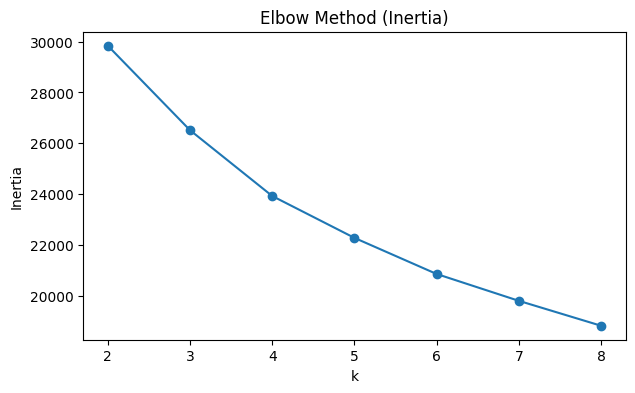

In [8]:
# Elbow (Inertia)
inertias = []
K = range(2, 9)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(7,4))
plt.plot(list(K), inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method (Inertia)")
plt.show()


Per decidir el nombre de clústers, s’ha utilitzat el mètode Elbow, que permet observar a partir de quin valor de k la millora del model comença a ser menor. Tal com es veu al gràfic, a mesura que augmenta k la inèrcia disminueix, però a partir d’un cert punt aquesta reducció ja no és tan significativa.

Aquest anàlisi ajuda a escollir un nombre de clústers adequat abans d’entrenar el model final.

In [9]:
# Silhouette
sil_scores = {}
for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores[k] = score
    print(f"k={k} → silhouette={score:.3f}")

best_k = max(sil_scores, key=sil_scores.get)
print("\nMillor k per silhouette (referència):", best_k, "→", round(sil_scores[best_k], 3))


k=2 → silhouette=0.236
k=3 → silhouette=0.202
k=4 → silhouette=0.159
k=5 → silhouette=0.147
k=6 → silhouette=0.153
k=7 → silhouette=0.151
k=8 → silhouette=0.149

Millor k per silhouette (referència): 2 → 0.236


En aquest cas s’ha utilitzat la mètrica Silhouette per mesurar com de ben separats estan els clústers. Els resultats mostren que el valor més alt s’obté amb k = 2, fet que indica que amb dos clústers la separació és més clara.

Tot i això, aquest valor s’utilitza com a referència, ja que també es té en compte el mètode Elbow i la interpretació esportiva dels clústers per decidir el nombre final de grups.

## 4) Entrenament final del K-Means

Triem un `k_final`.  



In [10]:
# Clustering final
# tria k basat en silhouette
k_final = best_k

kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# Assignem clúster només a les files que han entrat al model (les que no tenien NaNs)
df_model = df.loc[X.index].copy()
df_model["cluster"] = labels

df_model["cluster"].value_counts().sort_index()


cluster
0    2295
1    2286
Name: count, dtype: int64

Un cop analitzats els valors d’Elbow i Silhouette, s’ha escollit el valor de k que ofereix un millor equilibri segons les mètriques obtingudes. Amb aquest valor s’ha entrenat el model final de K-Means i s’han assignat els clústers corresponents a cada jugador.

El resultat mostra una distribució equilibrada dels registres entre els clústers, fet que indica que el model ha pogut separar els jugadors en grups diferenciats.

## 5) Taula resum per clúster (mitjanes)

En aquesta taula es mostren les mitjanes de les variables seleccionades per a cada clúster.
Aquesta informació és clau per poder analitzar i entendre quin tipus de jugador representa cada grup, a partir del seu rendiment i estil de joc.


In [11]:
cluster_summary = (
    df_model
    .groupby("cluster")[features]
    .mean()
    .round(3)
    .sort_index()
)

cluster_summary


,games,avg_min,avg_ast,avg_trb,avg_tov,avg_2pa,avg_3pa,fg2_pct,fg3_pct
cluster,,,,,,,,,
0,16.800,14.311,0.807,2.270,0.937,2.226,1.806,0.432,0.223
1,18.712,24.792,1.987,4.915,2.013,5.568,3.418,0.483,0.265


A partir de la taula de mitjanes es poden observar diferències clares entre els clústers obtinguts. Un dels grups presenta valors més alts en minuts, assistències, rebots i intents de tir, indicant una major participació en el joc, mentre que l’altre clúster mostra un perfil més moderat.

Aquesta taula permet identificar el rol predominant de cada clúster i facilita la interpretació esportiva dels resultats del model.

## 6) Assignació de noms esportius als clústers

Ara posem un nom a cada clúster.  
Mirarem quins valors destaquen (ús de 3p, rebots, assistències, etc.).



In [12]:
def assign_cluster_names(summary: pd.DataFrame) -> dict:
    names = {}
    
    # Helper per saber si existeixen columnes típiques
    has_usage3 = "usage_3p" in summary.columns
    has_usage2 = "usage_2p" in summary.columns
    has_ast = any(c in summary.columns for c in ["avg_ast", "ast", "avg_assists"])
    has_trb = any(c in summary.columns for c in ["avg_trb", "trb", "avg_reb"])
    has_pts = any(c in summary.columns for c in ["avg_pts", "pts", "avg_points"])
    
    # Assignem noms basats en regles senzilles
    for cl in summary.index:
        row = summary.loc[cl]
        
        # Obtenim valors rellevants 
        u3 = row.get("usage_3p", -np.inf)
        u2 = row.get("usage_2p", -np.inf)
        ast = row.get("avg_ast", row.get("ast", -np.inf))
        trb = row.get("avg_trb", row.get("trb", -np.inf))
        pts = row.get("avg_pts", row.get("pts", -np.inf))
        
        # Regles simples d'assignació
        if has_usage3 and u3 >= summary["usage_3p"].quantile(0.75):
            names[cl] = "Tiradors exteriors"
        elif has_trb and trb >= summary[[c for c in summary.columns if "trb" in c or c=="trb"]].max().max() * 0.95:
            names[cl] = "Interiors físics"
        elif has_ast and ast >= summary[[c for c in summary.columns if "ast" in c]].max().max() * 0.95:
            names[cl] = "Bases generadors"
        elif has_pts and pts >= summary[[c for c in summary.columns if "pts" in c]].max().max() * 0.95:
            names[cl] = "Anotadors principals"
        else:
            names[cl] = "Jugadors equilibrats"
    
    
    return names

cluster_names = assign_cluster_names(cluster_summary)
cluster_names


{0: 'Jugadors equilibrats', 1: 'Interiors físics'}

In [13]:
df_model["cluster_name"] = df_model["cluster"].map(cluster_names)
df_model["cluster_name"].value_counts()


cluster_name
Jugadors equilibrats    2295
Interiors físics        2286
Name: count, dtype: int64

Un cop obtinguda la taula resum amb les mitjanes, s’han assignat noms esportius a cada clúster segons les variables que més destaquen en cada grup, com ara els rebots, les assistències o l’ús del tir.

D’aquesta manera, els clústers es poden interpretar més fàcilment, associant cada grup a un perfil de jugador concret, com ara jugadors equilibrats o interiors físics.

## 7) Visualització simple: PCA 2D

Fem una reducció de dimensions amb **PCA** (2 components) i pintem els jugadors per color segons el clúster.  


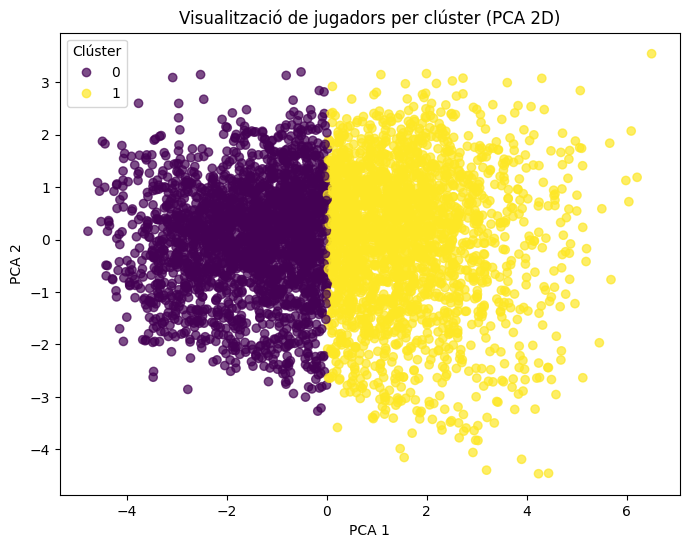

In [14]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=df_model["cluster"],
    alpha=0.7
)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Visualització de jugadors per clúster (PCA 2D)")
plt.legend(*scatter.legend_elements(), title="Clúster", loc="best")
plt.show()


En aquest pas s’ha utilitzat la tècnica PCA per reduir les dades a dues dimensions i poder representar visualment els jugadors. Al gràfic es pot observar com els jugadors es distribueixen en dos grups diferenciats segons el clúster assignat pel model.

Aquesta visualització permet comprovar de manera visual que el clustering ha separat els jugadors en perfils diferents, facilitant la comprensió dels resultats obtinguts.

## Exportació de dades a CSV

In [15]:
# Exportació del dataset final per a Power BI

output_path = "output_clustering_powerbi.csv"
df_model.to_csv(output_path, index=False)

print(f"Dataset exportat correctament a: {output_path}")


Dataset exportat correctament a: output_clustering_powerbi.csv


## Comentaris i interpretació dels resultats

En aquest treball s’ha utilitzat un model de clustering per agrupar els jugadors segons les seves estadístiques. Després de provar diferents valors de k, s’ha observat que amb k = 2 els grups queden més clars i millor separats.

Tot i que també s’ha provat k = 4 per obtenir més perfils, finalment s’ha escollit k = 2 perquè els resultats són més fàcils d’interpretar i més coherents amb les dades.